# Modelos del lenguaje con RNNs

En esta parte, vamos a entrenar un modelo del lenguaje basado en caracteres con Recurrent Neural Networks. Asimismo, utilizaremos el modelo para generar texto. En particular, alimentaremos nuestro modelo con obras de la literatura clásica en castellano para obtener una red neuronal que sea capaz de "escribir" fragmentos literarios.

Los entrenamientos para obtener un modelo de calidad podrían tomar cierto tiempo (5-10 minutos por epoch), por lo que se aconseja empezar a trabajar pronto. El uso de GPUs no ayuda tanto con LSTMs como con CNNs, por lo que si tenéis máquinas potentes en casa es posible que podáis entrenar más rápido o a la misma velocidad que en Colab. En todo caso, la potencia de Colab es más que suficiente para completar esta actividad con éxito.

<center><img src="https://upload.wikimedia.org/wikipedia/commons/d/d8/El_ingenioso_hidalgo_don_Quijote_de_la_Mancha.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consistirá en un archivo de texto con el contenido íntegro en castellano antiguo de El Ingenioso Hidalgo Don Quijote de la Mancha, disponible de manera libre en la página de [Project Gutenberg](https://www.gutenberg.org). Asimismo, como apartado optativo en este laboratorio se pueden utilizar otras fuentes de texto. Aquí podéis descargar los datos a utilizar de El Quijote y un par de obras adicionales:

[El ingenioso hidalgo Don Quijote de la Mancha (Miguel de Cervantes)](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219424&authkey=AH0gb-qSo5Xd7Io)

[Compilación de obras teatrales (Calderón de la Barca)](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219433&authkey=AKvGD6DC3IRBqmc)

[Trafalgar (Benito Pérez Galdós)](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219434&authkey=AErPCAtMKOI5tYQ)

Como ya deberíamos de estar acostumbrados en problemas de Machine Learning, es importante echar un vistazo a los datos antes de empezar.

## 1. Carga y procesado del texto

Primero, vamos a descargar el libro e inspeccionar los datos. El fichero a descargar es una versión en .txt del libro de Don Quijote, a la cual se le han borrado introducciones, licencias y otras secciones para dejarlo con el contenido real de la novela.

In [1]:
import numpy as np
import keras
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.utils import to_categorical


In [2]:
path = keras.utils.get_file(
    fname="don_quijote.txt",
    origin=" https://raw.githubusercontent.com/JaznaLaProfe/Deep-Learning/main/textos/Don_Quijote_de_la_Mancha.txt"
)

Una vez descargado, vamos a leer el contenido del fichero en una variable. Adicionalmente, convertiremos el contenido del texto a minúsculas para ponérselo un poco más fácil a nuestro modelo (de modo que todas las letras sean minúsculas y el modelo no necesite diferenciar entre minúsculas y mayúsculas).

**1.1.** Leer todo el contenido del fichero en una única variable ***text*** y convertir el string a minúsculas

In [3]:
# Abrir y leer el contenido
with open(path, 'r', encoding='utf-8') as f:
    texto = f.read()

# Mostrar los primeros 500 caracteres (por ejemplo)
print(texto[:500])

Capítulo primero. Que trata de la condición y ejercicio del famoso hidalgo
don Quijote de la Mancha


En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho
tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua,
rocín flaco y galgo corredor. Una olla de algo más vaca que carnero,
salpicón las más noches, duelos y quebrantos los sábados, lantejas los
viernes, algún palomino de añadidura los domingos, consumían las tres
partes de su hacienda. El resto della co


Podemos comprobar ahora que efectivamente nuestra variable contiene el resultado deseado, con el comienzo tan característico del Quijote.

In [4]:
print("Longitud del texto: {}".format(len(texto)))
print(texto[0:300])

Longitud del texto: 2071198
Capítulo primero. Que trata de la condición y ejercicio del famoso hidalgo
don Quijote de la Mancha


En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho
tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua,
rocín flaco y galgo corredor. Una olla de algo más


In [5]:
texto = texto.lower()
print(texto[0:300])

capítulo primero. que trata de la condición y ejercicio del famoso hidalgo
don quijote de la mancha


en un lugar de la mancha, de cuyo nombre no quiero acordarme, no ha mucho
tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua,
rocín flaco y galgo corredor. una olla de algo más


## 2. Procesado de los datos

Una de las grandes ventajas de trabajar con modelos que utilizan caracteres en vez de palabras es que no necesitamos tokenizar el texto (partirlo palabra a palabra). Nuestro modelo funcionará directamente con los caracteres en el texto, incluyendo espacios, saltos de línea, etc.

Antes de hacer nada, necesitamos procesar el texto en entradas y salidas compatibles con nuestro modelo. Como sabemos, un modelo del lenguaje con RNNs acepta una serie de caracteres y predice el siguiente carácter en la secuencia.

* "*El ingenioso don Qui*" -> predicción: **j**
* "*El ingenioso don Quij*" -> predicción: **o**

De modo que la entrada y la salida de nuestro modelo necesita ser algo parecido a este esquema. En este punto, podríamos usar dos formas de preparar los datos para nuestro modelo.

1. **Secuencia a secuencia**. La entrada de nuestro modelo sería una secuencia y la salida sería esa secuencia trasladada un caracter a la derecha, de modo que en cada instante de tiempo la RNN tiene que predecir el carácter siguiente. Por ejemplo:

>* *Input*:   El ingenioso don Quijot
>* *Output*: l ingenioso don Quijote

2. **Secuencia a carácter**. En este variante, pasaríamos una secuencia de caracteres por nuestra RNN y, al llegar al final de la secuencia, predeciríamos el siguiente carácter.

>* *Input*:   El ingenioso don Quijot
>* *Output*: e

En este laboratorio, por simplicidad, vamos a utilizar la segunda variante.

De este modo, a partir del texto, hemos de generar nuestro propio training data que consista en secuencias de caracteres con el siguiente carácter a predecir. Para estandarizar las cosas, utilizaremos secuencias de tamaño *SEQ_LENGTH* caracteres (un hiperparámetro que podemos elegir nosotros).



#### 2.1. Obtención de los caracteres y mapas de caracteres

Antes que nada, necesitamos saber qué caracteres aparecen en el texto, ya que tendremos que diferenciarlos mediante un índice de 0 a *num_chars* - 1 en el modelo. Obtener:


1.   Número de caracteres únicos que aparecen en el texto.
2.   Diccionario que asocia char a índice único entre 0 y *num_chars* - 1. Por ejemplo, {'a': 0, 'b': 1, ...}
3.   Diccionario reverso de índices a caracteres: {0: 'a', 1: 'b', ...}


In [6]:
## TU CÓDIGO AQUÍ

# Lista de caracteres únicos
chars = sorted(set(texto))

# Número total de caracteres únicos
num_chars = len(chars)

# Mapa char → índice
char2idx = {char: idx for idx, char in enumerate(chars)}

# Mapa índice → char
idx2char = {idx: char for char, idx in char2idx.items()}

In [7]:
num_chars

61

#### 2.2. Obtención de secuencias de entrada y carácter a predecir

Ahora, vamos a obtener las secuencias de entrada en formato texto y los correspondientes caracteres a predecir. Para ello, recorrer el texto completo leído anteriormente, obteniendo una secuencia de SEQ_LENGTH caracteres y el siguiente caracter a predecir. Una vez hecho, desplazarse un carácter a la izquierda y hacer lo mismo para obtener una nueva secuencia y predicción. Guardar las secuencias en una variable ***sequences*** y los caracteres a predecir en una variable ***next_chars***.

Por ejemplo, si el texto fuera "Don Quijote" y SEQ_LENGTH fuese 5, tendríamos

* *sequences* = ["Don Q", "on Qu", "n Qui", " Quij", "Quijo", "uijot"]
* *next_chars* = ['u', 'i', 'j', 'o', 't', 'e']

In [8]:
# Definimos el tamaño de las secuencias. Puedes dejar este valor por defecto.
SEQ_LENGTH = 15

sequences = []
next_chars = []

## TU CÓDIGO AQUÍ
for i in range(len(texto) - SEQ_LENGTH):
    seq = texto[i:i + SEQ_LENGTH]
    next_char = texto[i + SEQ_LENGTH]

    sequences.append(seq)
    next_chars.append(next_char)

print(sequences[:3])
print(next_chars[:3])

['capítulo primer', 'apítulo primero', 'pítulo primero.']
['o', '.', ' ']


Indicar el tamaño del training set que acabamos de generar.

In [9]:
## TU CÓDIGO AQUÍ
training_set_size = len(sequences)
print("Tamaño del training set:", training_set_size)

Tamaño del training set: 2071183


Como el Quijote es muy largo y tenemos muchas secuencias, podríamos encontrar problemas de memoria. Por ello, vamos a elegir un número máximo de ellas. Si estás corriendo esto localmente y tienes problemas de memoria, puedes reducir el tamaño aún más, pero ten cuidado porque, a menos datos, peor calidad del modelo.

In [10]:
MAX_SEQUENCES = 250000

perm = np.random.permutation(len(sequences))
sequences, next_chars = np.array(sequences), np.array(next_chars)
sequences, next_chars = sequences[perm], next_chars[perm]
sequences, next_chars = list(sequences[:MAX_SEQUENCES]), list(next_chars[:MAX_SEQUENCES])

print(len(sequences))

250000


#### 2.3. Obtención de input X y output y para el modelo

Finalmente, a partir de los datos de entrenamiento que hemos generado vamos a crear los arrays de datos X e y que pasaremos a nuestro modelo.

Para ello, vamos a utilizar *one-hot encoding* para nuestros caracteres. Por ejemplo, si sólo tuviéramos 4 caracteres (a, b, c, d), las representaciones serían: (1, 0, 0, 0), (0, 1, 0, 0), (0, 0, 1, 0) y (0, 0, 0, 1).

De este modo, **X** tendrá shape *(num_sequences, seq_length, num_chars)* e **y** tendrá shape *(num_sequences, num_chars)*.



In [11]:
NUM_CHARS = num_chars  # Tu número de caracteres distintos aquí
NUM_SEQUENCES = len(sequences)
X = np.zeros((NUM_SEQUENCES, SEQ_LENGTH, NUM_CHARS))
y = np.zeros((NUM_SEQUENCES, NUM_CHARS))

## Tu código para rellenar X e y aquí. Pista: utilizar el diccionario de
## chars a índices obtenido anteriormente junto con numpy. Por ejemplo,
## si hacemos
##     X[0, 1, char_to_indices['a']] = 1
## estamos diciendo que para la segunda posición de la primera secuencia se
## tiene una 'a'

## TU CÓDIGO AQUÍ

for i, sequence in enumerate(sequences):
    for t, char in enumerate(sequence):
        X[i, t, char2idx[char]] = 1  # convertimos char a índice con char2idx
    y[i, char2idx[next_chars[i]]] = 1

Debido a lo solicitado el unico preprocesamiento realizado es el cambio a minusculas del texto original.

## 3. Definición del modelo y entrenamiento

Una vez tenemos ya todo preparado, es hora de definir el modelo. Define un modelo que utilice una **LSTM** con **128 unidades internas**. Si bien el modelo puede definirse de una manera más compleja, para empezar debería bastar con una LSTM más una capa Dense con el *softmax* que predice el siguiente caracter a producir. Adam puede ser una buena elección de optimizador.

Una vez el modelo esté definido, entrénalo un poco para asegurarte de que la loss es decreciente. No es necesario guardar la salida de este entrenamiento en el entregable final, ya que vamos a hacer el entrenamiento más informativo en el siguiente punto.

In [12]:
## TU CÓDIGO AQUÍ
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(SEQ_LENGTH, NUM_CHARS)),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(NUM_CHARS, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy'
)

model.summary()

history = model.fit(X, y, epochs=10, batch_size=32)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        97,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 61)             │         7,869 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,149 (410.74 KB)

 Trainable params: 105,149 (410.74 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 2.3953
Epoch 2/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - loss: 1.8367
Epoch 3/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 1.6805
Epoch 4/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 1.5848
Epoch 5/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 1.5164
Epoch 6/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 1.4749
Epoch 7/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 1.4312
Epoch 8/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - loss: 1.4013
Epoch 9/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - loss: 1.3714
Epoch 10/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 1.3537


Para ver cómo evoluciona nuestro modelo del lenguaje, vamos a generar texto según va entrenando. Para ello, vamos a programar una función que, utilizando el modelo en su estado actual, genere texto, con la idea de ver cómo se va generando texto al entrenar cada epoch.

En el código de abajo podemos ver una función auxiliar para obtener valores de una distribución multinomial. Esta función se usará para muestrear el siguiente carácter a utilizar según las probabilidades de la salida de softmax (en vez de tomar directamente el valor con la máxima probabilidad, obtenemos un valor aleatorio según la distribución de probabilidad dada por softmax, de modo que nuestros resultados serán más diversos, pero seguirán teniendo "sentido" ya que el modelo tenderá a seleccionar valores con más probabilidad).



In [13]:
def sample(probs, temperature=1.0):
    """Nos da el índice del elemento a elegir según la distribución
    de probabilidad dada por probs.

    Args:
      probs es la salida dada por una capa softmax:
        probs = model.predict(x_to_predict)[0]

      temperature es un parámetro que nos permite obtener mayor
        "diversidad" a la hora de obtener resultados.

        temperature = 1 nos da la distribución normal de softmax
        0 < temperature < 1 hace que el sampling sea más conservador,
          de modo que sampleamos cosas de las que estamos más seguros
        temperature > 1 hace que los samplings sean más atrevidos,
          eligiendo en más ocasiones clases con baja probabilidad.
          Con esto, tenemos mayor diversidad pero se cometen más
          errores.
    """
    # Cast a float64 por motivos numéricos
    probs = np.asarray(probs).astype('float64')

    # Hacemos logaritmo de probabilidades y aplicamos reducción
    # por temperatura.
    probs = np.log(probs) / temperature

    # Volvemos a aplicar exponencial y normalizamos de nuevo
    exp_probs = np.exp(probs)
    probs = exp_probs / np.sum(exp_probs)

    # Hacemos el sampling dadas las nuevas probabilidades
    # de salida (ver doc. de np.random.multinomial)
    samples = np.random.multinomial(1, probs, 1)
    return np.argmax(samples)


Utilizando la función anterior y el modelo entrenado, vamos a añadir un callback a nuestro modelo para que, según vaya entrenando, veamos los valores que resultan de generar textos con distintas temperaturas al acabar cada epoch.

Para ello, abajo tenéis disponible el callback *on_epoch_end*. Esta función elige una secuencia de texto al azar en el texto disponible en la variable
text y genera textos de longitud *GENERATED_TEXT_LENGTH* según las temperaturas en *TEMPERATURES_TO_TRY*, utilizando para ello la función *generate_text*.

Completa la función *generate_text* de modo que utilicemos el modelo y la función sample para generar texto.

NOTA: Cuando hagas model.predict, es aconsejable usar verbose=0 como argumento para evitar que la función imprima valores de salida.

In [14]:
TEMPERATURES_TO_TRY = [0.2, 0.5, 1.0, 1.2]
GENERATED_TEXT_LENGTH = 100

def generate_text(seed_text, model, length, temperature=1):
    """Genera una secuencia de texto a partir de seed_text utilizando model.

    La secuencia tiene longitud length y el sampling se hace con la temperature
    definida.
    """
    generated = seed_text
    input_indices = [char2idx[c] for c in seed_text]

    for _ in range(length):
        x_pred = np.zeros((1, SEQ_LENGTH, NUM_CHARS))
        for t, idx in enumerate(input_indices):
            x_pred[0, t, idx] = 1

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = idx2char[next_index]

        generated += next_char
        input_indices.append(next_index)
        input_indices = input_indices[1:]

    return generated

def on_epoch_end(epoch, logs):
    # Solo ejecutar en las épocas 1 y 100
    if epoch not in [0, 99]:
        return

    print("\n\n\n")
    start_pos = random.randint(0, len(texto) - SEQ_LENGTH - 1)
    seed_text = texto[start_pos:start_pos + SEQ_LENGTH]

    for temperature in TEMPERATURES_TO_TRY:
        print("------> Epoch: {} - Generando texto con temperature {}".format(
            epoch + 1, temperature))

        generated_text = generate_text(seed_text, model,
                                       GENERATED_TEXT_LENGTH, temperature)
        print("Seed: {}".format(seed_text))
        print("Texto generado: {}".format(generated_text))
        print()

generation_callback = LambdaCallback(on_epoch_end=on_epoch_end)


Entrena ahora tu modelo. No te olvides de añadir *generation_callback* a la lista de callbacks utilizados en fit(). Ya que las métricas de clasificación no son tan críticas aquí (no nos importa tanto acertar el carácter exacto, sino obtener una distribución de probabilidad adecuada), no es necesario monitorizar la accuracy ni usar validation data, si bien puedes añadirlos para asegurarte de que todo está en orden.


## Modelo
Se eligió utilizar una LSTM en lugar de una RNN porque tiene una mejor capacidad para recordar lo que se ha generado anteriormente. Esto se debe a las compuertas internas que posee la LSTM, las cuales le permiten retener y controlar la información importante generada anteriormente, dando mayor relevancia al contexto previo en la generación del texto.

Como el modelo debe generar texto carácter por carácter, es importante que mantenga el contexto para que las frases tengan sentido. Las RNN tienden a olvidar rápidamente la información anterior, mientras que las LSTM permite recordar información pasada.

Gracias a esto, el modelo puede generar un texto que parezca más coherente y natural para el lector.

In [15]:
## TU CÓDIGO AQUÍ
model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(SEQ_LENGTH, NUM_CHARS)),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(NUM_CHARS, activation='softmax')
], name="modelo2")

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

model2.summary()

Model: "modelo2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 256)            │       325,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 61)             │        15,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 341,309 (1.30 MB)

 Trainable params: 341,309 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history2 = model2.fit(
    X, y,
    epochs=100,
    batch_size=64,
    callbacks=[generation_callback]
)

Epoch 1/100
3899/3907 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2895 - loss: 2.4583



------> Epoch: 1 - Generando texto con temperature 0.2
Seed: ,
puestas sus m
Texto generado: ,
puestas sus manos, que es mano de la cabeza de la cabeza de la cabeza de la caballería de su casa y de la cabeza 

------> Epoch: 1 - Generando texto con temperature 0.5
Seed: ,
puestas sus m
Texto generado: ,
puestas sus más se la ha de hacer de pellado de la primera pasa de la contenía me ha de no la cabeza de las cabez

------> Epoch: 1 - Generando texto con temperature 1.0
Seed: ,
puestas sus m
Texto generado: ,
puestas sus más bien he ventera, de la poñía yo a tanto no sa cahión a don quijote- a
saber entre
la escodrí, con

------> Epoch: 1 - Generando texto con temperature 1.2
Seed: ,
puestas sus m
Texto generado: ,
puestas sus mozar y quizó el don quijote a su habe. y, había fuera; a otras asillas, alco; por dios, promipilar
m

3907/3907 ━━━━━━━━━━━━━━━━━━━━ 49s 12ms/step - accuracy: 0.2896 - lo

In [17]:
model2.save("model2_lstm256_dropout03.keras")

In [18]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(SEQ_LENGTH, NUM_CHARS)),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CHARS, activation='softmax')
], name="modelo3")
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

model3.summary()

Model: "modelo3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 15, 256)        │       325,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 61)             │         7,869 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 891,709 (3.40 MB)

 Trainable params: 891,709 (3.40 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history3 = model3.fit(
    X, y,
    epochs=100,
    batch_size=64,
    callbacks=[generation_callback]
)

Epoch 1/100
3906/3907 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2965 - loss: 2.4053



------> Epoch: 1 - Generando texto con temperature 0.2
Seed: la sed, que
qui
Texto generado: la sed, que
quisiere que le así se la casa y con la caballería de la cabeza de la caballería de la cabeza de la cab

------> Epoch: 1 - Generando texto con temperature 0.5
Seed: la sed, que
qui
Texto generado: la sed, que
quisiésese que eston muy bien a su compañía, pues, a casto que en la mano y harmo hujer no estuento a c

------> Epoch: 1 - Generando texto con temperature 1.0
Seed: la sed, que
qui
Texto generado: la sed, que
quiso vorsión.
   a debin ser él descosotras saliendo sus matudas.
 
 a horma de bosigen, se ahora dond

------> Epoch: 1 - Generando texto con temperature 1.2
Seed: la sed, que
qui
Texto generado: la sed, que
quisiésele alveria y blelado al penenciañe a los:rio en esto, tal y seré sucedimo, haréistes manerques 

3907/3907 ━━━━━━━━━━━━━━━━━━━━ 57s 14ms/step - accuracy: 0.2965 - lo

In [22]:
model3.save("model3_lstm256x2_dropout03_lstm128.keras")

Para la arquitectura del modelo se utilizó una estructura simple, una capa LSTM con 256 neuronas, seguida de una capa Dropout, y finalmente una capa de salida con activación softmax, encargada de predecir el siguiente carácter.

En cuanto a los hiperparámetros, el modelo fue entrenado durante 100 épocas, utilizando un batch size de 64.  

A medida que el modelo va entrenando, se realizan pruebas con diferentes textos en distintas épocas para observar su evolución y verificar si aprende a generar texto de forma coherente.

En estas pruebas también se utiliza diferentes valores de temperatura, lo que permite al modelo generar texto con mayor o menor nivel de creatividad.  

Segido de este modelo se estableció un segundo modelo en el cual su arquitectura esta conforma por dos capas lstm de 256 neuronas, una capa de dropout y una ultima lstm con 128 neuronas. Observando el loss se puede apreciar una evolución e incluso un loss de menor valor que el modelo anterior, se realizaran graficos para tener algo mas representativo de su evolución.

## Evaluación y análisis

En este caso específico, el modelo no puede ser evaluado de forma convencional, como se haría comparando sus resultados con datos reales y/o conocidos, ya que su objetivo es generar texto nuevo que no existía previamente.

Por lo tanto, la evaluación se basa principalmente en la coherencia y del texto generado y si tiene alguna sentido al momento de leerlo.

Para la evaluación del modelo, se utilizó principalmente la métrica de loss, ya que esta mide qué tan bien el modelo está aprendiendo a predecir el siguiente carácter durante el entrenamiento.  

La otra forma de evaluar ya es de forma manual, que un humano lea lo que genere el modelo y evalue si lo que genera tiene sentido.

In [48]:
model_list = {
    'model1_simple_lstm128_dropout': model2,
    'model2_lstm256x2_dropout_lstm128': model3
}

In [49]:
model_name2 = list(model_list.keys())[0]

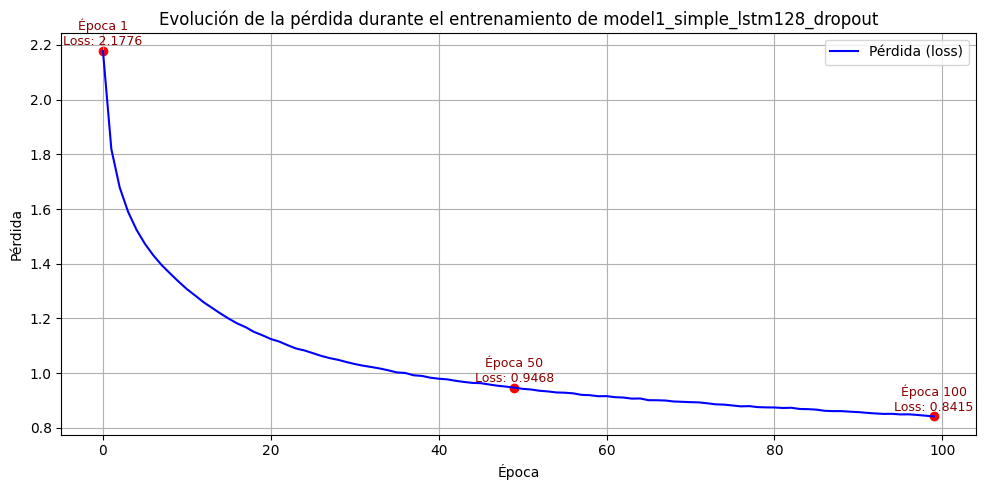

In [50]:
loss_values = history2.history['loss']
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Pérdida (loss)', color='blue')

epochs_to_annotate = [0, 49, 99]
for epoch in epochs_to_annotate:
    plt.scatter(epoch, loss_values[epoch], color='red')
    plt.text(epoch, loss_values[epoch] + 0.01, f'Época {epoch + 1}\nLoss: {loss_values[epoch]:.4f}',
             ha='center', va='bottom', fontsize=9, color='darkred')

plt.title(f'Evolución de la pérdida durante el entrenamiento de {model_name2}')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
model_name3 = list(model_list.keys())[1]

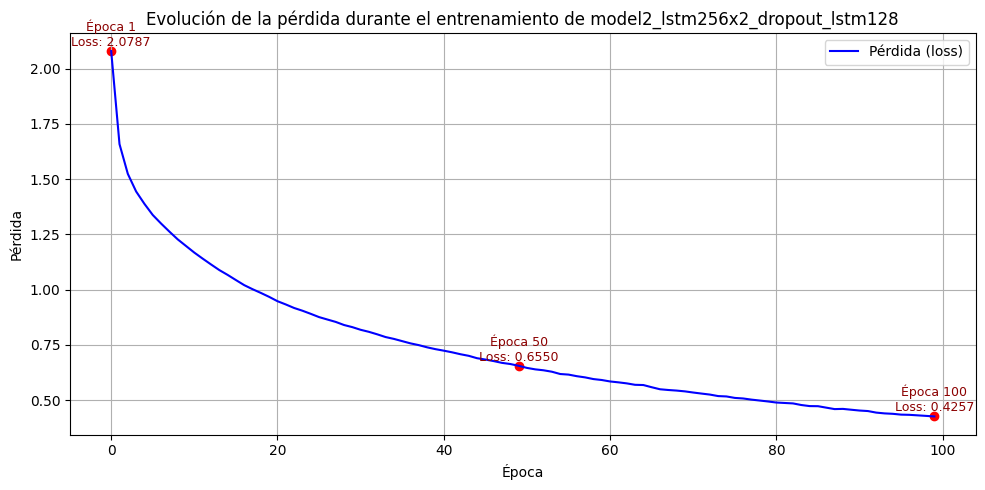

In [52]:
loss_values = history3.history['loss']
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Pérdida (loss)', color='blue')

epochs_to_annotate = [0, 49, 99]
for epoch in epochs_to_annotate:
    plt.scatter(epoch, loss_values[epoch], color='red')
    plt.text(epoch, loss_values[epoch] + 0.01, f'Época {epoch + 1}\nLoss: {loss_values[epoch]:.4f}',
             ha='center', va='bottom', fontsize=9, color='darkred')

plt.title(f'Evolución de la pérdida durante el entrenamiento de {model_name3}')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Se observa la evolución del modelo 1 en base a la métrica loss, la cual indica que durante la fase de entrenamiento el modelo va mejorando su capacidad para predecir correctamente el siguiente carácter.  
Y en el modelo 2 se observa que tiene mejor rendimiento en la fase de entrenamiento en loss, esto se debe principalmente a la arquitectura del modelo.

## Prueba

Finalmente se realizo nuevas pruebas con los modelo, en especifico con 2 frases nueva y con diferentes temperaturas para visualizar que generan los modelos.

In [53]:
seeds = [
    "el caballero tomó su lanza",
    "y sanch"
]

temperaturas = [0.2, 0.5, 1.0, 1.5]

In [54]:
def sample_with_temperature(preds, temperature):
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


def generar_texto(seed, model, length, temperature):
    generated = seed.lower()
    for _ in range(length):
        input_seq = [char2idx.get(c, 0) for c in generated[-SEQ_LENGTH:]]
        input_seq = to_categorical(input_seq, num_classes=len(chars))
        input_seq = np.expand_dims(input_seq, axis=0)

        preds = model.predict(input_seq, verbose=0)[0]

        next_idx = sample_with_temperature(preds, temperature)
        next_char = idx2char[next_idx]
        generated += next_char
    return generated

In [55]:
for model_name, model in model_list.items():
    print(f"\n\nGenerando texto con modelo: {model_name} ")
    for seed in seeds:
        print(f"\n=== Seed: '{seed}' ===")
        for temp in temperaturas:
            print(f"\n--- Temperature: {temp} ---")
            texto_generado = generar_texto(seed, model, length=100, temperature=temp)
            print(texto_generado)



Generando texto con modelo: model1_simple_lstm128_dropout 

=== Seed: 'el caballero tomó su lanza' ===

--- Temperature: 0.2 ---
el caballero tomó su lanza, y si no se hay más que dechr de la mancha, y no os por las manos que tenía en este tiempo que habe

--- Temperature: 0.5 ---
el caballero tomó su lanza, se paseciéndo esta altancía me llamo el caballero de la mancha había de acometer y desencaba de la

--- Temperature: 1.0 ---
el caballero tomó su lanza, y enga aquella de nuestro
caballero.

-bien es esto bien yo dél y la voluntad de la sintencio. ase

--- Temperature: 1.5 ---
el caballero tomó su lanza, y habías visto se le pomos puertos:


-¡ya nuevo vivida de
vuesa ser..

! ''todo esto alxe le cont

=== Seed: 'y sanch' ===

--- Temperature: 0.2 ---
y sancho panza, llegarán a la caballería aronder de su alma a entender en el castillo de aquella antes que 

--- Temperature: 0.5 ---
y sancho panza la que para tocar en la carga que la paga, y la altera en sancho; y él lo estuba en

Con las pruebas ya realizadas se evidencia la influencia de la temperatura seleccionada al momento de la generación del texto.  
Aun asi con temperaturas bajas el modelo no genera texto muy coherente, o al menos no que va de acuerdo a un contexto.  

Y tiende a usar mas caracteres y/o palabras de forma seguida como los conectores en general, las causas de esto es el pre procesamiento realizada ya que se puede considerar nulo y tambien por el texto del quijote en si, ya que es un español bastante "antiguo" y el modelo tiende a usar en mayor medida ciertos caracteres ya que estos deben estar con bastante frecuencia en el texto original.

## Entregable

Completa los apartados anteriores para entrenar modelos del lenguaje que sean capaces de generar texto con cierto sentido. Comentar los resultados obtenidos y cómo el modelo va mejorando época a época. Comentar las diferencias apreciadas al utilizar diferentes valores de temperatura. Entregar al menos la salida de un entrenamiento completo con los textos generados época a época.

El objetivo no es conseguir generar pasajes literarios con coherencia, sino obtener lenguaje que se asemeje en cierta manera a lo visto en el texto original y donde las palabras sean reconocibles como construcciones en castellano. Como ejemplo de lo que se puede conseguir, este es el resultado de generar texto después de 10 epochs y con temperature 0.2:


```
-----> Epoch: 10 - Generando texto con temperature 0.2
Seed: o le cautivaron y rindieron el
Texto generado: o le cautivaron y rindieron el caballero de la caballería de la mano de la caballería del cual se le dijo:

-¿quién es el verdad de la caballería de la caballería de la caballería de la caballería de la caballería, y me ha de habían de la mano que el caballero de la mano de la caballería. y que no se le habían de la mano de la c

```

Asimismo, se proponen los siguientes aspectos opcionales para conseguir nota extra:

*   Experimentar con los textos de teatro en verso de Calderón de la Barca (¿es capaz el modelo de aprender las estructuras del teatro en verso?) o con alguno de los otros textos disponibles. También se puede probar con textos de vuestra elección.
*   Experimentar con distintos valores de SEQ_LENGTH.
*   Experimentar con los hiperparámetros del modelo o probar otro tipo de modelos como GRUs o *stacked* RNNs (RNNs apiladas).
*   Experimentar utilizando embeddings en vez de representaciones one-hot.
*   (Difícil) Entrenar un modelo secuencia a secuencia en vez de secuencia a carácter.


